In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise import dump
from surprise.model_selection import GridSearchCV
import csv
from surprise.model_selection import GridSearchCV
from surprise import accuracy

In [2]:
csv_path = os.path.join("../data/csv/clean_reviews_reduced.csv")
TextFileReader = pd.read_csv(csv_path, chunksize=1000)  # the number of rows per chunk

dfList = []
for df in TextFileReader:
    dfList.append(df)

df = pd.concat(dfList,sort=False)

# df = pd.DataFrame()
# for chunk in pd.read_csv(csv_path, header=None, chunksize=1000):
#     df = pd.concat([df, chunk], ignore_index=True)


In [3]:
df.head()

,beer_id,username,score
0,78143,dtx00,4.50
1,49537,bauermj,4.00
2,206689,SenorHops,4.35
3,8322,bigeyedfish89,4.04
4,2093,PhxHorn,3.65


In [5]:
# A reader is needed but only the rating_scale param is requiered.
reader=Reader(rating_scale=(0,5))
# The columns must correspond to user id, item id and ratings (in that order). Names are irrelevent
data = Dataset.load_from_df(df[['username', 'beer_id', 'score']], reader)

In [8]:
# sample random trainset and testset method
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE and MAE
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.3971
MAE:  0.2837


0.28367762725555123

In [9]:
# Lets try to tune the SVD algorithm parameters using GridsearchCV!
# we will use 3 fold cross validation method to save some time
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.4174768748806427
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


### Lets try KNN

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1701A028>,
      dtype=object)

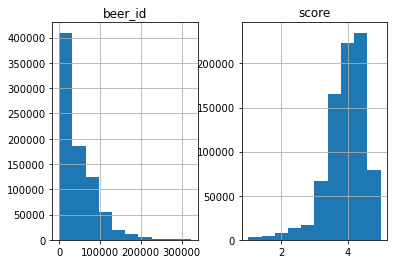

In [8]:
df2 = df.sample(n=1000000)
df2 = df2.groupby('beer_id').filter(lambda x: len(x) > 100)
df2.hist()

In [9]:
df2['beer_id'].value_counts()

11757     2362
2093      2156
1093      2048
29619     1989
19960     1942
          ... 
269906     101
726        101
252234     101
86298      101
93125      101
Name: beer_id, Length: 2875, dtype: int64

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 814647 entries, 1686153 to 535178
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   beer_id   814647 non-null  int64  
 1   username  814647 non-null  object 
 2   score     814647 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 21.8+ MB


In [11]:
# sample random trainset and testset method
# test set is made of 25% of the ratings. we are looking at similarities between items (user_based=false)
reader=Reader(rating_scale=(0,5))
data = Dataset.load_from_df(df2[['username', 'beer_id', 'score']], reader)

trainset, testset = train_test_split(data, test_size=.25)

sim_options = {'name': 'pearson',
               'user_based': False
               }

# We'll use KNN.
algo = KNNBasic(sim_options=sim_options)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.fit(trainset).test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.5578


0.5578368672130221

In [14]:
beer_raw_id = 79835 #Elder Betty a Fruit and Field Beer
beer_inner_id = algo.trainset.to_inner_iid(beer_raw_id)
beer_neighbors = algo.get_neighbors(beer_inner_id, k=10)
beer_neighbors = (algo.trainset.to_raw_iid(inner_id)
                  for inner_id in beer_neighbors)
print('The 10 nearest neighbors of 79835 are:')
for beer in beer_neighbors:
    print(beer)

The 10 nearest neighbors of 79835 are:
104918
256144
79373
77648
1822
42296
74634
26290
38515
197183


In [15]:
beer_raw_id = 11757 #Breakfast Stout
beer_inner_id = algo.trainset.to_inner_iid(beer_raw_id)
beer_neighbors = algo.get_neighbors(beer_inner_id, k=10)
beer_neighbors = (algo.trainset.to_raw_iid(inner_id)
                  for inner_id in beer_neighbors)
print('The 10 nearest neighbors of 79835 are:')
for beer in beer_neighbors:
    print(beer)

The 10 nearest neighbors of 79835 are:
48050
9590
41091
142974
1608
269906
20714
73943
57319
221622


In [16]:
beer_raw_id = 2093 #90 Minute IPA
beer_inner_id = algo.trainset.to_inner_iid(beer_raw_id)
beer_neighbors = algo.get_neighbors(beer_inner_id, k=10)
beer_neighbors = (algo.trainset.to_raw_iid(inner_id)
                  for inner_id in beer_neighbors)
print('The 10 nearest neighbors of 79835 are:')
for beer in beer_neighbors:
    print(beer)

The 10 nearest neighbors of 79835 are:
61554
57088
70102
63511
302060
46467
81543
741
3245
1520


In [ ]:
pred